# Object detection and localization 

**This notebook is on implementing basic object detection and localization on Pascal-VOC dataset using pre-trained Resnet model and fastai library built on top of pytorch. The code base is taken from fastai deep learning part2 course taught by Jeremy Howard. https://github.com/fastai/fastai/blob/master/courses/dl2/** 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import torch

from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [2]:
from pdb import set_trace

### Loading data, creating labels/annotations and defining helper functions

In [3]:
PATH = Path('data/pascal-voc/')

Path returns a path object

In [4]:
list(PATH.iterdir())

[PosixPath('data/pascal-voc/pascal_train2007.json'),
 PosixPath('data/pascal-voc/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal-voc/pascal_test2007.json'),
 PosixPath('data/pascal-voc/tmp'),
 PosixPath('data/pascal-voc/pascal_val2012.json'),
 PosixPath('data/pascal-voc/VOCdevkit'),
 PosixPath('data/pascal-voc/pascal_train2012.json'),
 PosixPath('data/pascal-voc/pascal_val2007.json')]

As well as the images, there are also *annotations* - *bounding boxes* showing where each object is. These were hand labeled. The original version were in XML, which is a little hard to work with nowadays, so we uses the more recent JSON version which you can download from [this link](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip).

In [5]:
!ls data/pascal-voc/

pascal_test2007.json   pascal_val2007.json  VOCdevkit
pascal_train2007.json  pascal_val2012.json  VOCtrainval_06-Nov-2007.tar
pascal_train2012.json  tmp


Loading annotations for training data

In [6]:
f = (PATH/'pascal_train2007.json').open()

In [7]:
f

<_io.TextIOWrapper name='data/pascal-voc/pascal_train2007.json' mode='r' encoding='UTF-8'>

In [8]:
trn_j = json.load(f)

In [9]:
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [10]:
images, types, annotations, categories = ['images', 'type', 'annotations', 'categories']

In [11]:
images

'images'

In [12]:
type(trn_j[images])

list

In [13]:
len(trn_j[images])

2501

We have 2500 images in the training dataset

In [14]:
trn_j[images][0]

{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500}

images have image file name, height and width plus it's id

In [15]:
trn_j[types]

'instances'

In [16]:
trn_j[annotations][0]

{'area': 34104,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0,
 'image_id': 12,
 'iscrowd': 0,
 'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}

The bounding box in default is: 155 x coordinate, 96 y coordinate and the box is 174 is the height and 196 is the width of the box. image_id is the id to recognize image and category_id is to map it to categories

In [17]:
trn_j[categories][0]

{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'}

Storing category_id to category_name

In [18]:
cats_list = dict((o['id'], o['name']) for o in trn_j[categories])

In [19]:
cats_list

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

So we have 20 object categories

Storing image filename along with it's ID

In [20]:
trn_fn = dict((o['id'], o['file_name']) for o in trn_j[images])

Storing just the id of the images in a list

In [21]:
trn_id = [e['id'] for e in trn_j[images]]

In [22]:
imgs = 'VOCdevkit/VOC2007/JPEGImages'

In [23]:
imgs_path = PATH/imgs

In [24]:
list(imgs_path.iterdir())[0]

PosixPath('data/pascal-voc/VOCdevkit/VOC2007/JPEGImages/000671.jpg')

Switching the bounding box dimensions in numpy format with upper left and lower right coordinates

In [25]:
o = trn_j[annotations][0]

In [26]:
o

{'area': 34104,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0,
 'image_id': 12,
 'iscrowd': 0,
 'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}

In [27]:
bb = o['bbox']

In [28]:
bb

[155, 96, 196, 174]

In [29]:
bb[3]+bb[1]-1

269

Bounding box is converted from top left coordinate, width and height to 2 coordinate definition (top left and bottom right)

In [30]:
trn_anno = collections.defaultdict(lambda: [])
for o in trn_j[annotations]:
    if not o['ignore']:
        bb = o['bbox']
        bb = np.array([bb[1], bb[0], bb[3] + bb[1] - 1, bb[2] + bb[0] - 1])
        trn_anno[o['image_id']].append((bb, o['category_id']))

len(trn_anno)

2501

In [31]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [32]:
cats_list[7]

'car'

In [33]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

This image has 2 bounding boxes

In [34]:
cats_list[15],cats_list[13]

('person', 'horse')

In [35]:
def bb_hw(bb_ul):
    '''
    convert 2 coordinate definition to one coordinate width-heigth definition
    '''
    return np.array(
        [bb_ul[1], bb_ul[0], bb_ul[3] - bb_ul[1] + 1, bb_ul[2] - bb_ul[0] + 1])

In [36]:
sample = trn_j[images][8]

In [37]:
sample

{'file_name': '000036.jpg', 'height': 500, 'id': 36, 'width': 332}

In [38]:
trn_anno[36]

[(array([ 78,  26, 343, 318]), 12)]

In [39]:
sample['file_name'],sample['id']

('000036.jpg', 36)

In [40]:
imgs_path

PosixPath('data/pascal-voc/VOCdevkit/VOC2007/JPEGImages')

In [41]:
im = open_image(imgs_path/sample['file_name'])

In [42]:
def show_img(im, figsize=None, ax=None):
    '''
    Plot the image on the axes passed.
    If not passed then create a new axes
    '''
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)  #remove the axis
    ax.get_yaxis().set_visible(False)
    return ax

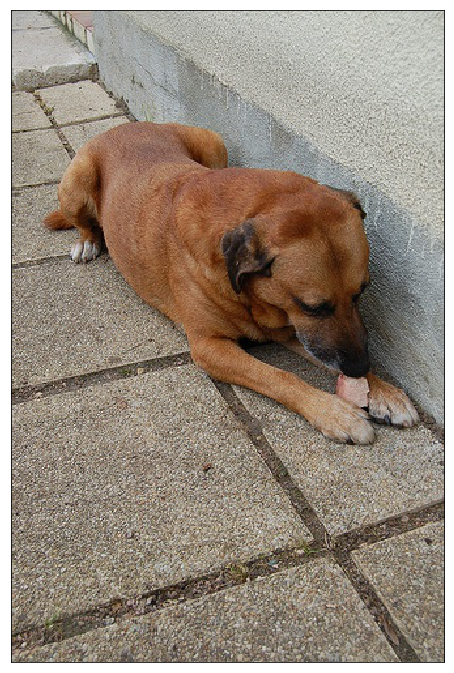

In [43]:
o = show_img(im,(12,12))

In [44]:
def draw_outline(o, lw):
    '''
    create visible outline irrespective of background color of image
    '''
    o.set_path_effects([
        patheffects.Stroke(linewidth=lw, foreground='black'),
        patheffects.Normal()
    ])

In [45]:
def draw_rect(ax, b):
    '''
    create bounding box
    '''
    patch = ax.add_patch(
        patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [46]:
def draw_text(ax, xy, txt, sz=14):
    '''
    positioning text on the plot
    '''
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [47]:
im_bb = trn_anno[36][0][0]

In [48]:
im_cat = trn_anno[36][0][1]

In [49]:
bb_hw(im_bb)

array([ 26,  78, 293, 266])

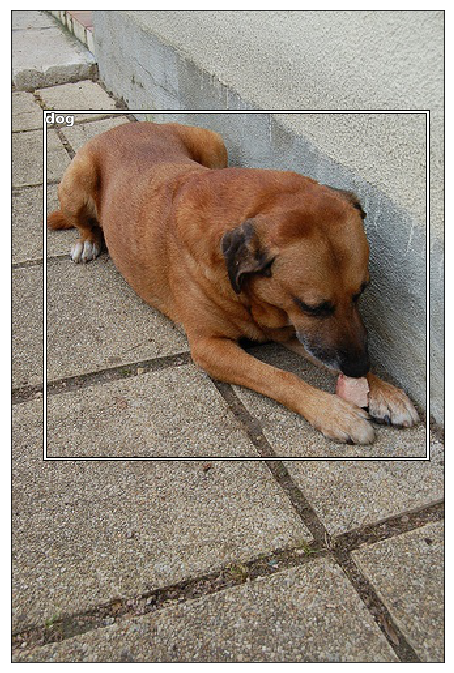

In [50]:
ax = show_img(im,(12,12))
b = bb_hw(im_bb)
draw_rect(ax, b)
draw_text(ax, b[:2], cats_list[im_cat])

In [51]:
def draw_im(im, ann):
    '''
    Draw bounding box and label for each object in the image
    '''
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats_list[c], sz=16)

In [52]:
def draw_idx(i):
    '''
    Showing images with annotations and bb for every object in the image
    '''
    im_a = trn_anno[i]
    im = open_image(imgs_path/trn_fn[i])
    print(im.shape)
    draw_im(im, im_a)

(500, 360, 3)


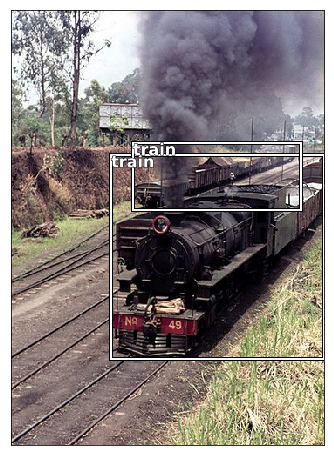

In [53]:
draw_idx(34)

### Largest item classifier

First we'll try to identify the largest object in the image

#### Getting bounding box for the largest object in the image

In [54]:
#finds the bounding box for the largest object in the image: largest object is decided by the area
def get_lrg(b):
    '''
    return bounding box for the largest object in the image
    '''
    #     set_trace()
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:] - x[0][:2]), reverse=True)
    return b[0]

In [55]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

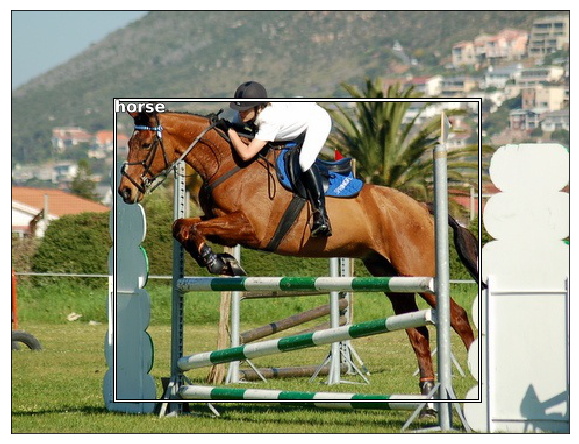

In [56]:
b,c = trn_lrg_anno[17]
b = bb_hw(b)
ax = show_img(open_image(imgs_path/trn_fn[17]), figsize=(10,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats_list[c], sz=16)

As we can see horse is the largest object in this picture as opposed to person

Storing the labels for the largest object as csv 

In [57]:
(PATH/'tmp').mkdir(exist_ok=True)

In [58]:
CSV = PATH/'tmp/lrg.csv'

In [59]:
CSV

PosixPath('data/pascal-voc/tmp/lrg.csv')

In [60]:
df = pd.DataFrame({'fn': [trn_fn[o] for o in trn_id],
    'cat': [cats_list[trn_lrg_anno[o][1]] for o in trn_id]}, columns=['fn','cat'])

In [61]:
df.head()

fn        cat
0  000012.jpg        car
1  000017.jpg      horse
2  000023.jpg     person
3  000026.jpg        car
4  000032.jpg  aeroplane

In [62]:
df.to_csv(CSV, index= False)

#### Model

In [63]:
f_model = resnet34
sz=224
bs=64

In [64]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

**Why transforms side on ?**

We are not cropping the image as we are finally going to be interested in bounding box over all the objects in image. We might lose part of image if we crop before feeding into model. But that we can do is squish the image to the required dimension

In [65]:
tfms = tfms_from_model(
    f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

In [66]:
x,y=next(iter(md.val_dl))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


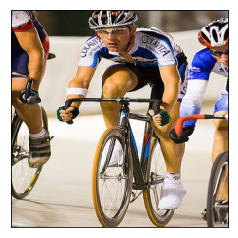

In [67]:
show_img(md.val_ds.denorm(to_np(x))[0])
#image looks squished due to crop type no and denorm for removing imagenet normalization

In [68]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [69]:
lrf=learn.lr_find(1e-5,100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:15<00:04,  1.66it/s, loss=11]  

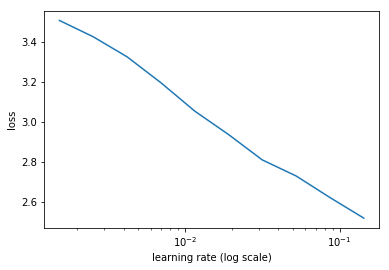

In [70]:
learn.sched.plot()

By default lr finder skips few point at the beginning and at the end (10 and 5), but in case of few mini-batches you can reduce this nummber to observe the uptick

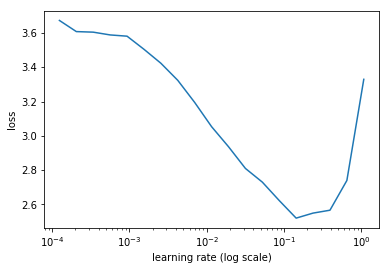

In [71]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [72]:
lr = 2e-2

In [73]:
learn.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))


  0%|          | 0/32 [00:00<?, ?it/s]                  

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.326093   0.623943   0.810847  



[0.6239426, 0.8108473569154739]

In [74]:
lrs = np.array([lr/1000,lr/100,lr])

In [75]:
learn.freeze_to(-2)

In [76]:
lrf=learn.lr_find(lrs/1000)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:20<00:03,  1.30it/s, loss=4.13] 

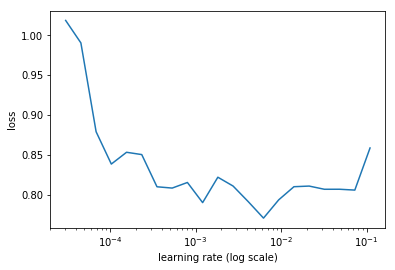

In [77]:
learn.sched.plot(1)

In [78]:
learn.fit(lrs/5, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 16%|█▌        | 5/32 [00:06<00:33,  1.23s/it, loss=0.735]


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      0.790852   0.590673   0.8128    



[0.59067315, 0.8128004819154739]

In [79]:
learn.unfreeze()

In [80]:
learn.fit(lrs/5, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.622706   0.537351   0.833233  
    1      0.426283   0.521832   0.852764                  



[0.5218321, 0.8527644202113152]

In [81]:
learn.save('class_one')

In [82]:
learn.load('class_one')

Prediction on a batch of image

In [83]:
x,y = next(iter(md.val_dl))

In [84]:
probs = F.softmax(predict_batch(learn.model, x), -1)

In [85]:
probs

Variable containing:
 4.5480e-06  1.7007e-01  1.3921e-05  ...   1.7497e-05  9.2726e-05  1.0972e-06
 4.2825e-06  3.3121e-06  1.4082e-06  ...   1.3563e-02  1.8609e-06  2.7785e-04
 4.2764e-06  4.9661e-07  9.9926e-01  ...   5.2873e-07  1.0414e-06  5.8167e-07
                ...                   ⋱                   ...                
 3.0670e-05  1.1117e-04  2.1155e-05  ...   2.6403e-02  3.1819e-05  2.1555e-04
 2.3301e-06  2.9154e-05  7.3766e-07  ...   1.7902e-04  1.7096e-06  8.2798e-06
 1.8925e-04  1.2146e-04  3.0317e-03  ...   4.7234e-04  7.4630e-04  5.0238e-04
[torch.cuda.FloatTensor of size 64x20 (GPU 0)]

In [86]:
x,preds = to_np(x),to_np(probs)

In [88]:
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


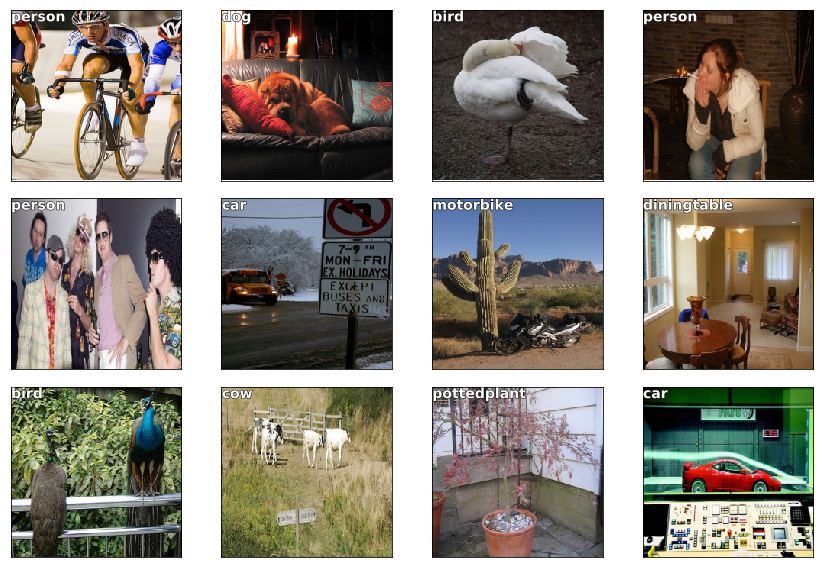

In [89]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

### BBox prediction

Now we are somewhat able to clas

Creating labels

In [90]:
BB_CSV = PATH/'tmp/bb.csv'

In [92]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_id])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fn[o] for o in trn_id], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [94]:
df.head()

fn            bbox
0  000012.jpg  96 155 269 350
1  000017.jpg   77 89 335 402
2  000023.jpg     1 2 461 242
3  000026.jpg  124 89 211 336
4  000032.jpg  77 103 182 374

In [95]:
f_model=resnet34
sz=224
bs=64

Set `continuous=True` to tell fastai this is a regression problem, which means it won't one-hot encode the labels, and will use MSE as the default crit.

Note that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.

Also, we use CropType.NO because we want to 'squish' the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects. (This is less of an issue in something like imagenet, where there is a single object to classify, and it's generally large and centrally located).

In [96]:
augs = [RandomFlip(), 
        RandomRotate(30),
        RandomLighting(0.1,0.1)]

In [97]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]


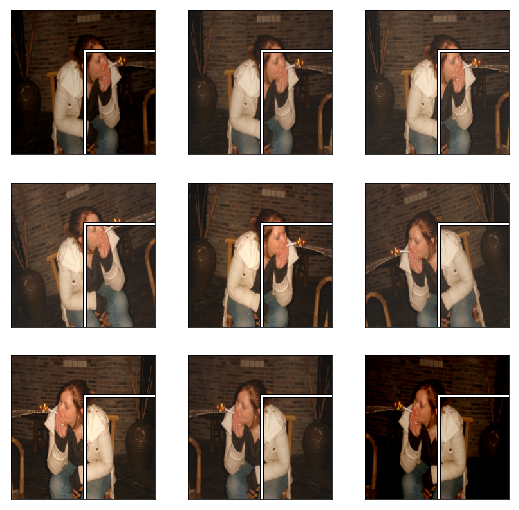

In [98]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [99]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [100]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[ 58.  28. 125. 195.]
[ 38.  23. 150. 200.]
[  0.   0. 208. 223.]
[ 64.  37. 108. 185.]
[ 21.   0. 197. 223.]
[ 52.  38. 106. 183.]
[ 37.  23. 152. 200.]
[ 47.  33. 119. 190.]
[ 12.   0. 185. 223.]


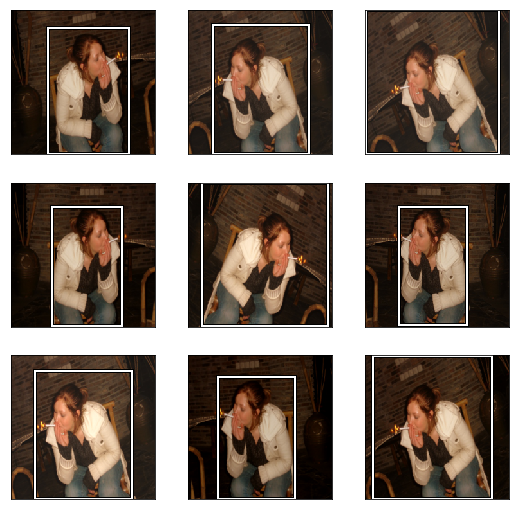

In [101]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [102]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

fastai let's you use a `custom_head` to add your own module on top of a convnet, instead of the adaptive pooling and fully connected net which is added by default. In this case, we don't want to do any pooling, since we need to know the activations of each grid cell.

The final layer has 4 activations, one per bounding box coordinate. Our target is continuous, not categorical, so the MSE loss function used does not do any sigmoid or softmax to the module outputs.

In [103]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss() #MAE loss

In [104]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:13<00:03,  1.84it/s, loss=446] 

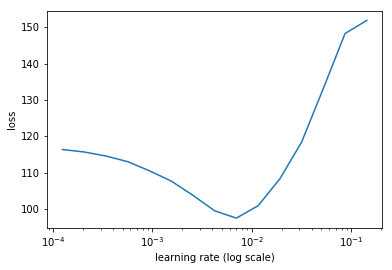

In [105]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [106]:
lr = 2e-3

In [107]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  3%|▎         | 1/32 [00:03<01:41,  3.27s/it, loss=119]

Exception in thread Thread-12:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                            
    0      49.71936   34.481659 
    1      38.065296  28.258522                           
    2      31.924194  27.562931                           



[27.562931]

In [108]:
lrs = np.array([lr/100,lr/10,lr])

In [109]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      79.46775   3857605675974656.0



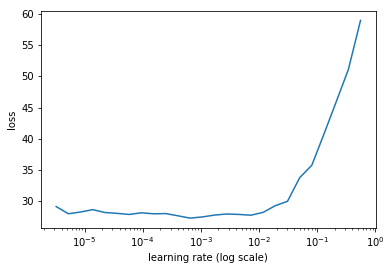

In [110]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [111]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      27.379776  24.312294 
    1      24.236854  21.636623                           
    2      20.358415  19.907764                           



[19.907764]

In [112]:
learn.freeze_to(-3)

In [113]:
learn.fit(lrs, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      17.981354  20.72171  
    1      16.224021  19.490541                           



[19.490541]

In [114]:
learn.save('reg4')

In [115]:
learn.load('reg4')

In [116]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


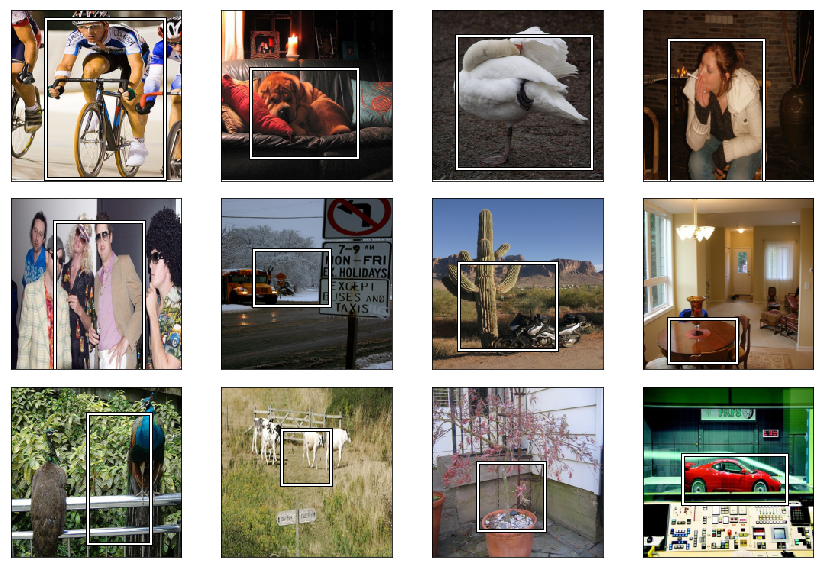

In [117]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()